Used Car Data Review
Gabriel Richards
September 2024

My name is Gabriel Richards and this Jupyter notebook reviews a dataset of used cars for sale. 

This notebook will examine the distributions of these measurements.

This study will examine the following questions:
The Torque and Power between Petrol and Diesel Engines will be compared. Which Engine type can produce more Torque? Which type can produce more Power?

Additionally, what cities are most common in the dataset?


In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy
from scipy.stats import mannwhitneyu
from IPython.display import display, Markdown



# Load the cardetails dataset into DataFrame
df = pd.read_csv('./data/cardetails.csv')

## Initial Data Inspection & Descriptive Statistics

# Inspect first few rows of the DataFrame
print(df.head())


            Make                            Model    Price  Year  Kilometer  \
0          Honda              Amaze 1.2 VX i-VTEC   505000  2017      87150   
1  Maruti Suzuki                  Swift DZire VDI   450000  2014      75000   
2        Hyundai             i10 Magna 1.2 Kappa2   220000  2011      67000   
3         Toyota                         Glanza G   799000  2019      37500   
4         Toyota  Innova 2.4 VX 7 STR [2016-2020]  1950000  2018      69000   

  Fuel_Type Transmission   Location   Color   Owner Seller_Type   Engine  \
0    Petrol       Manual       Pune    Grey   First   Corporate  1198 cc   
1    Diesel       Manual   Ludhiana   White  Second  Individual  1248 cc   
2    Petrol       Manual    Lucknow  Maroon   First  Individual  1197 cc   
3    Petrol       Manual  Mangalore     Red   First  Individual  1197 cc   
4    Diesel       Manual     Mumbai    Grey   First  Individual  2393 cc   

            Max_Power              Max_Torque Drivetrain  Length   W

Here is an excerpt of the top few rows of the data we will be examining. The libraries that will be used were imported.

In [30]:
print("Total Rows, Total Columns")
print(df.shape)




Total Rows, Total Columns
(2059, 20)


There are 20 columns and 2059 rows in this dataset. 

In [31]:
print(df.dtypes)

Make                   object
Model                  object
Price                   int64
Year                    int64
Kilometer               int64
Fuel_Type              object
Transmission           object
Location               object
Color                  object
Owner                  object
Seller_Type            object
Engine                 object
Max_Power              object
Max_Torque             object
Drivetrain             object
Length                float64
Width                 float64
Height                float64
Seating_Capacity      float64
Fuel_Tank_Capacity    float64
dtype: object


Here are each of the column names and their data type.

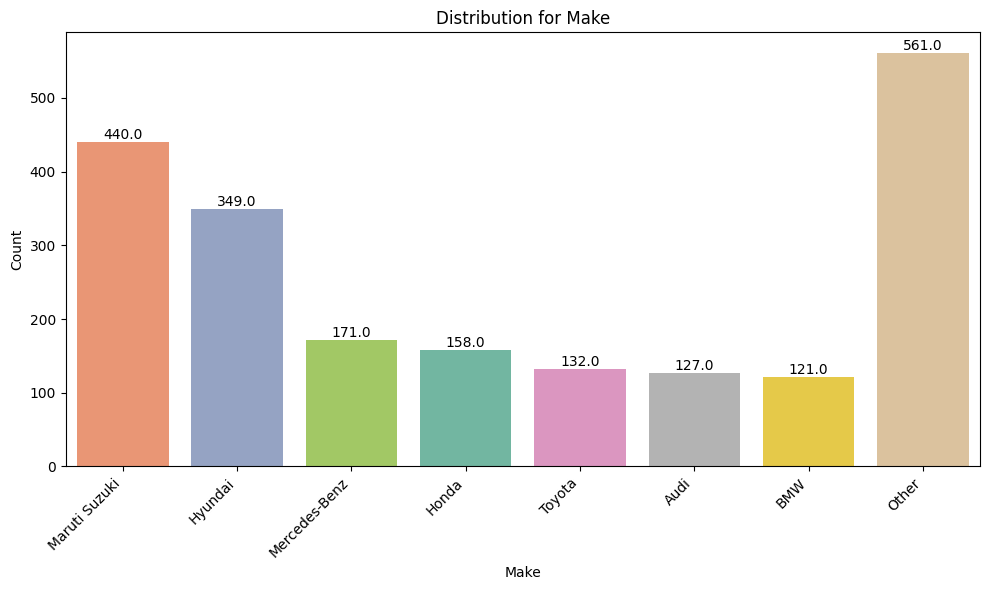

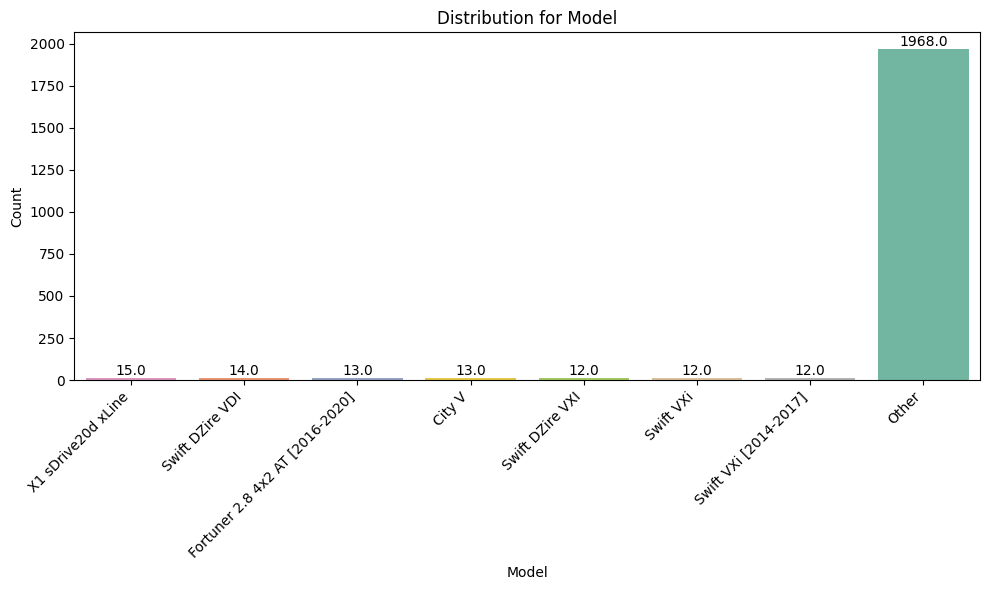

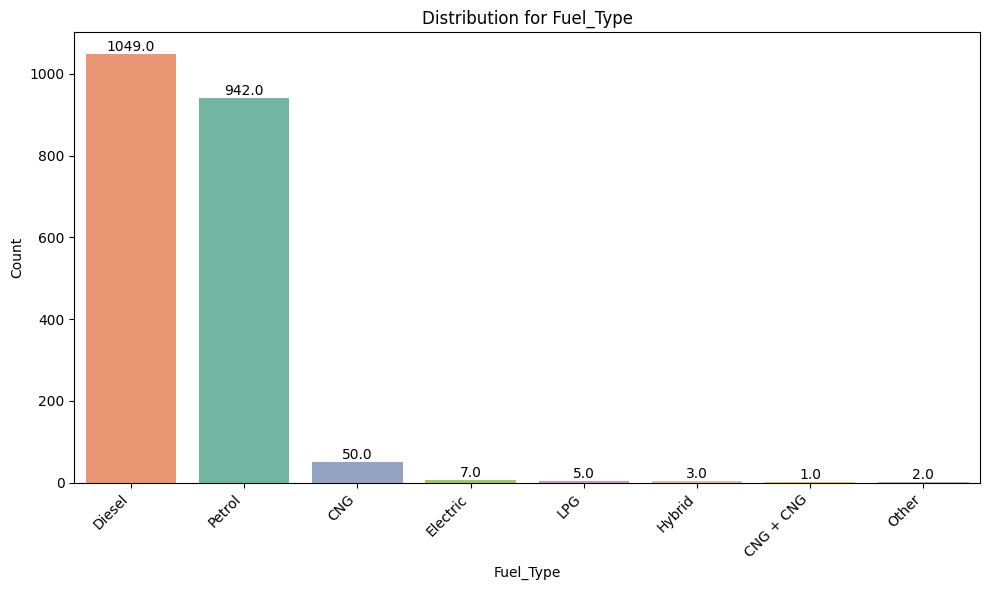

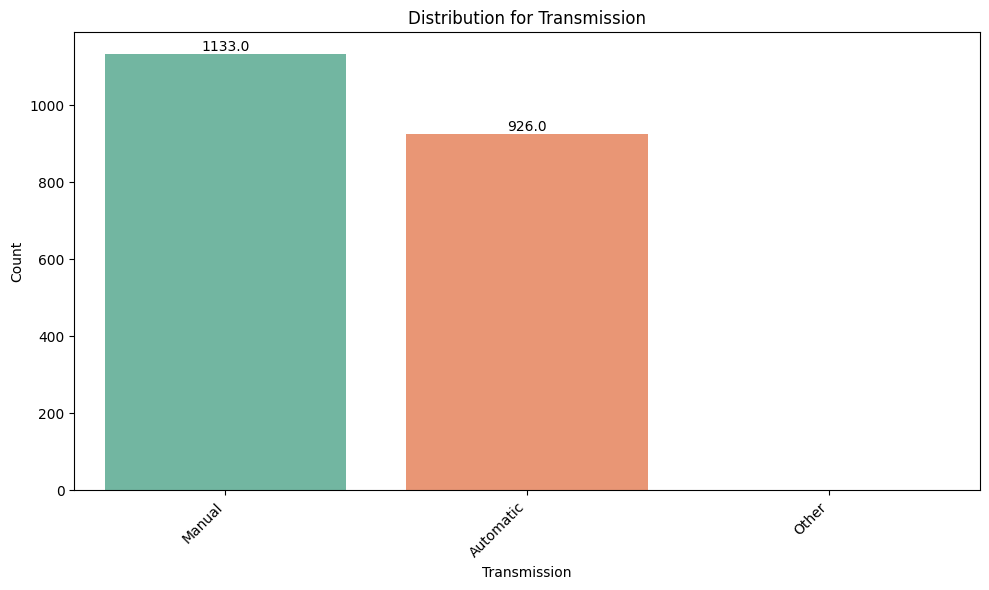

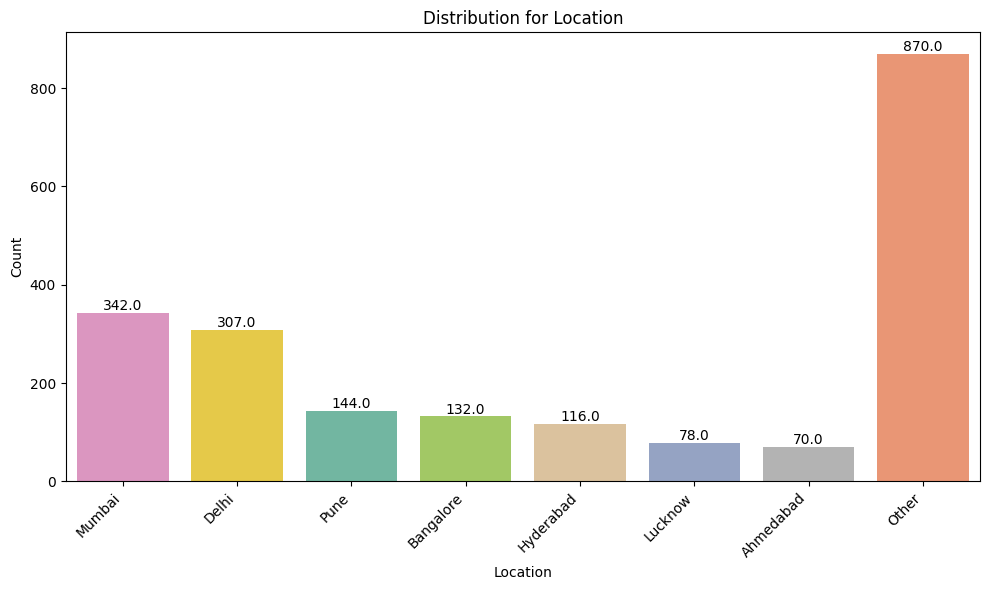

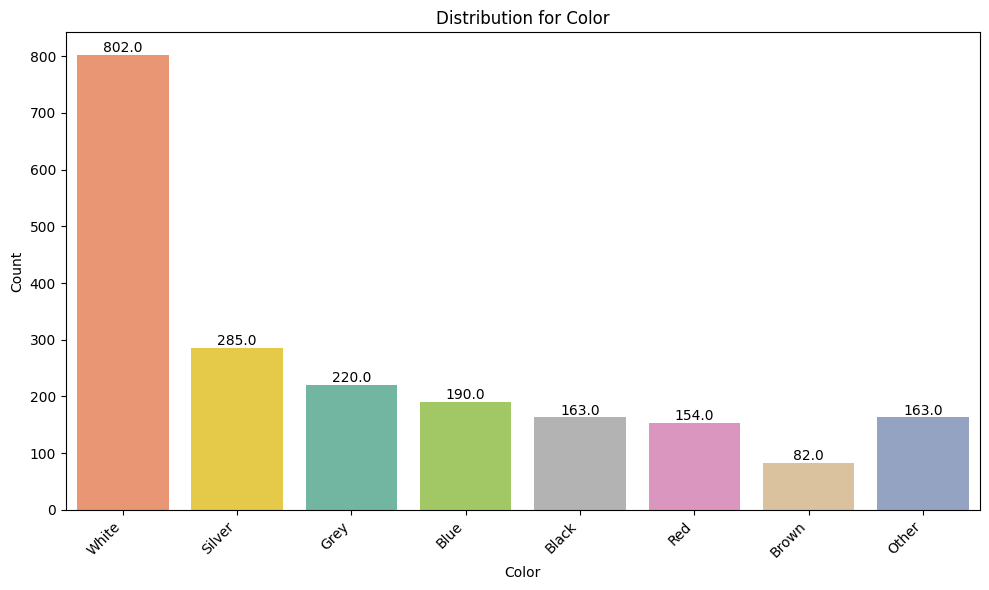

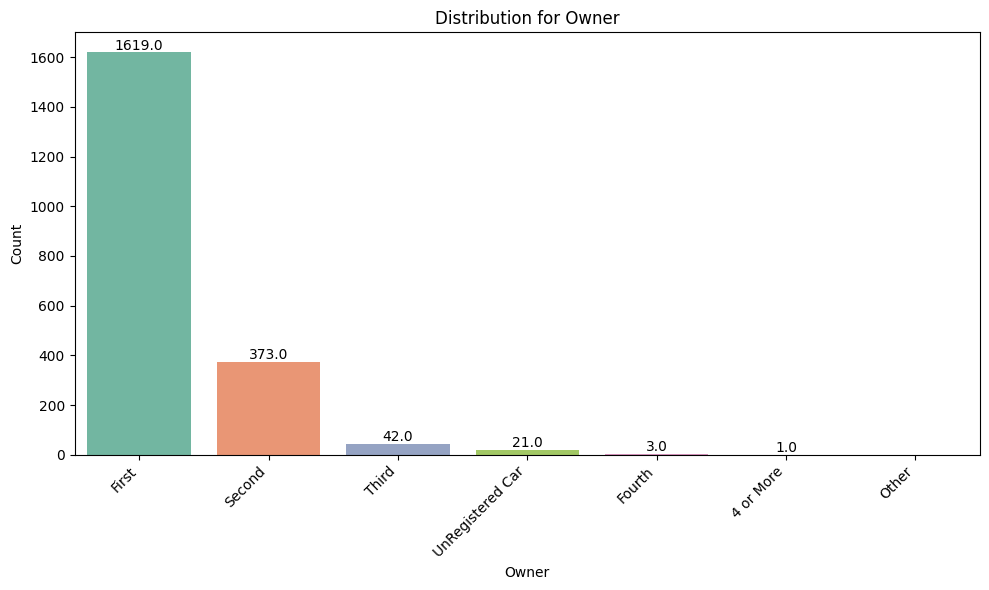

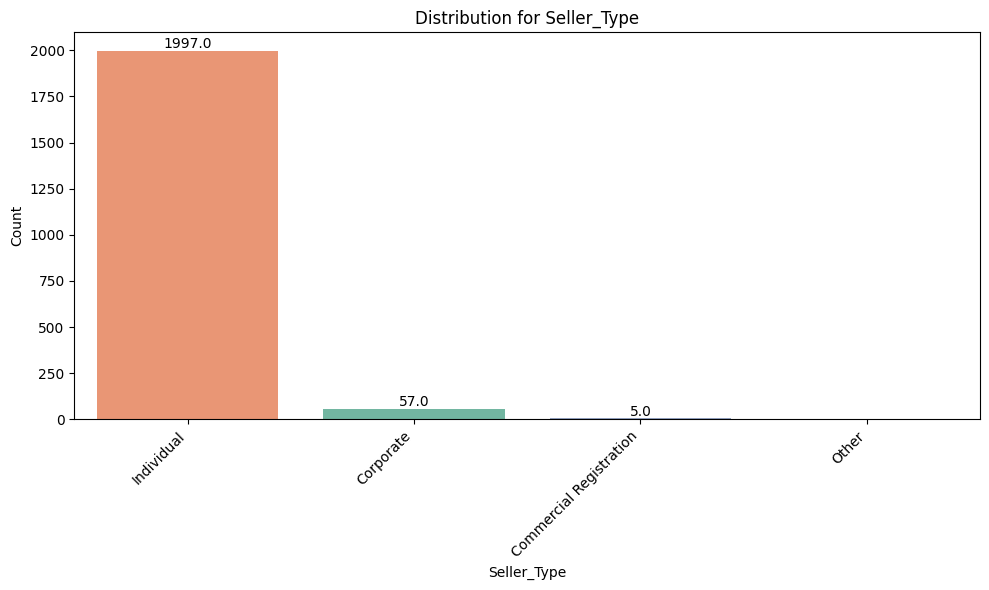

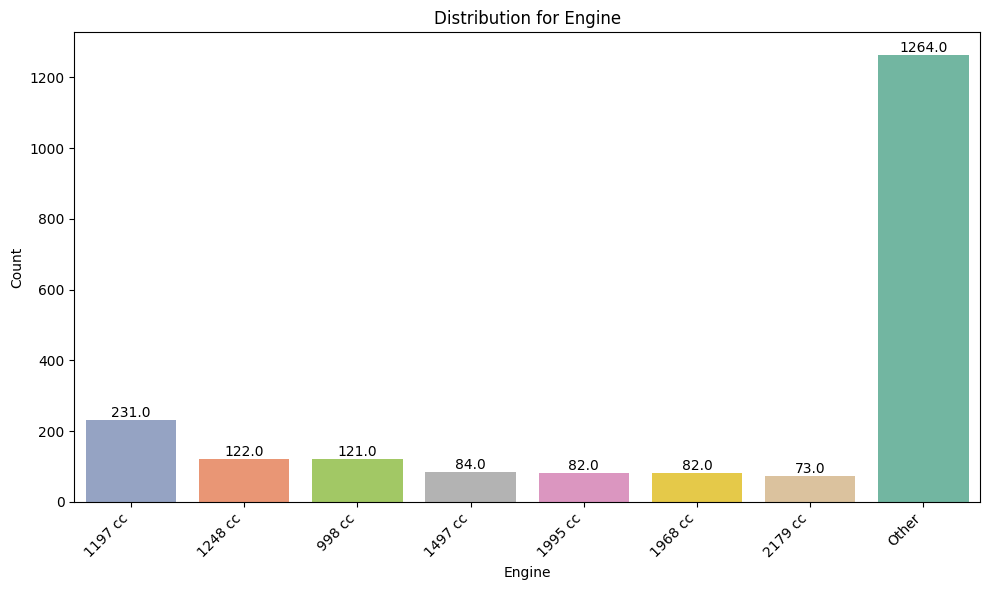

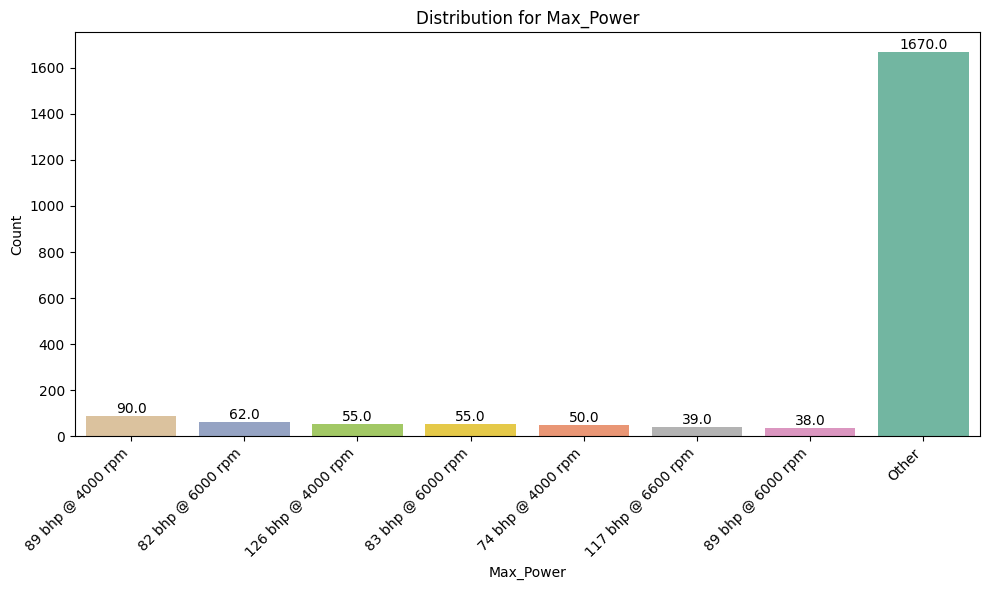

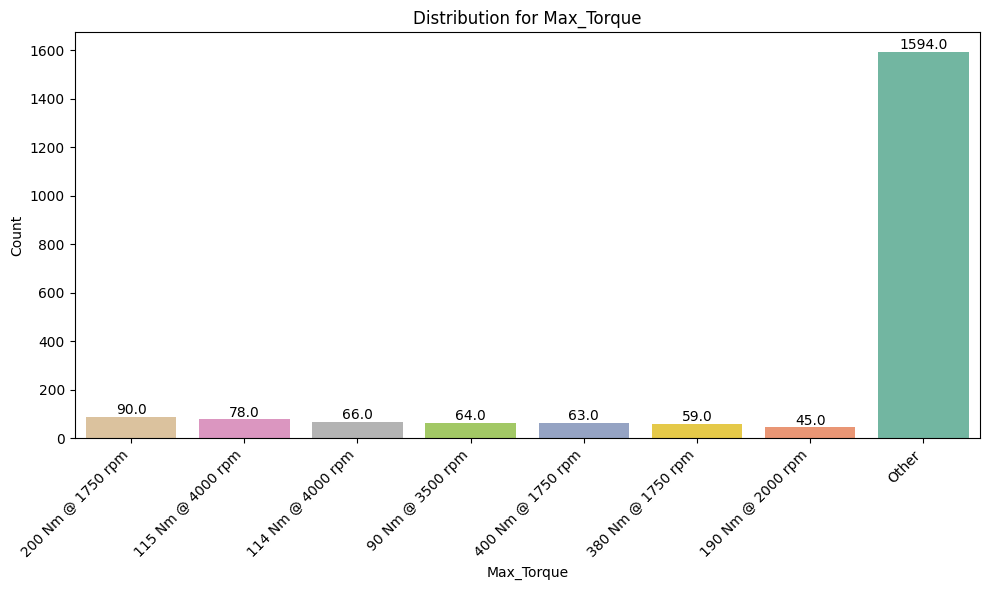

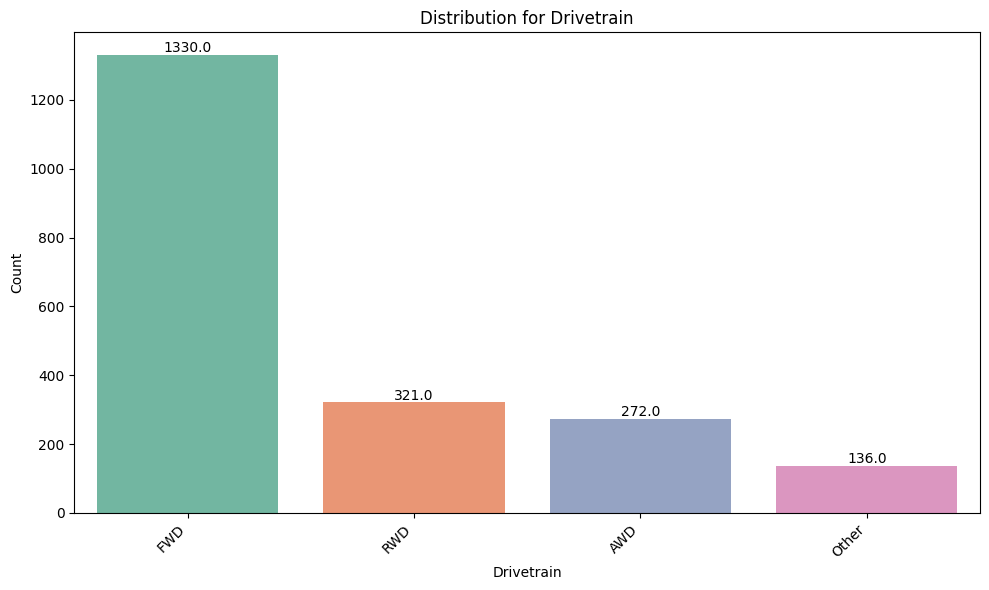

In [32]:
# Step 5. Initial Data Distribution for Categorical Column
# Function to group the top 7 frequent values, others into 'Other'
def group_top_7(df, col):
    # Get value counts for the column
    value_counts = df[col].value_counts()

    # Identify the top 7 most frequent values
    top_7_values = value_counts.index[:7]

    # Create a new column where the values not in the top 7 are grouped as 'Other'
    df[f'{col}_grouped'] = df[col].apply(lambda x: x if x in top_7_values else 'Other')

# Apply the function to each categorical column in the DataFrame
for col in df.select_dtypes(include=['object', 'category']).columns:
    group_top_7(df, col)

    # Recalculate value counts with 'Other' included
    grouped_value_counts = df[f'{col}_grouped'].value_counts()

    # Ensure 'Other' is always the first category
    categories = [cat for cat in grouped_value_counts.index if cat != 'Other'] + ['Other']

    # Create a count plot for the grouped data with 'Other' on the left
    plt.figure(figsize=(10, 6))  # Increase the figure size
    sns.countplot(x=f'{col}_grouped', hue=f'{col}_grouped', data=df, order=categories, palette="Set2", legend=False)

    # Add count labels above each bar
    for p in plt.gca().patches:
        height = p.get_height()
        plt.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    # Rotate x-axis labels to avoid collision and improve readability
    plt.xticks(rotation=45, ha='right')  # Rotate labels by 45 degrees

    # Add labels and title
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Distribution for {col}')

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent cutoff
    plt.show()

# Show all plots
plt.show()


This assignment required us to generate a histogram for all columns, however the basic commands generated way too many columns. It has been edited to solely provide the top 7 most frequent examples from each column, and pool the rest in the other category. We will proceed to look at some of these columns in greater detail.

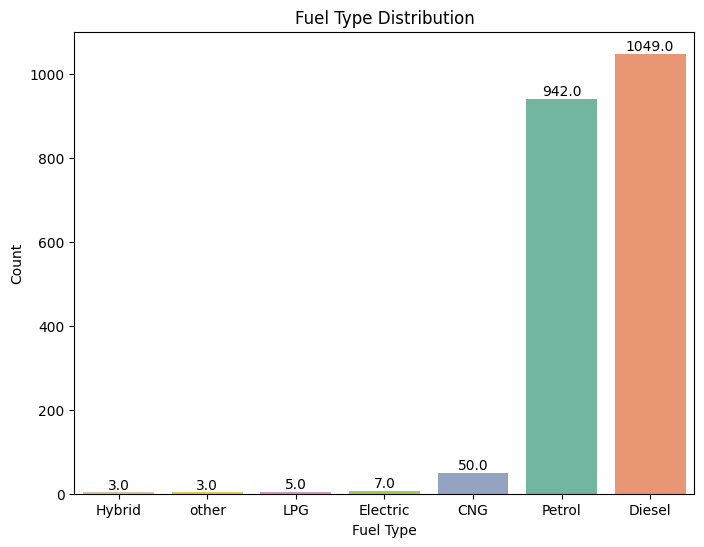

In [33]:
# Calculate the threshold for 0.1% of the total rows
threshold = len(df) * 0.001

# Calculate value counts for 'Fuel_Type'
fuel_counts = df['Fuel_Type'].value_counts()

# Identify fuel types that are below the threshold (outliers)
outlier_fuel_types = fuel_counts[fuel_counts < threshold].index

# Create a new column 'Fuel_Type_Grouped' where outliers are grouped as "other"
df['Fuel_Type_Grouped'] = df['Fuel_Type'].apply(lambda x: 'other' if x in outlier_fuel_types else x)

# Recalculate the counts, including the "other" category
fuel_counts_grouped = df['Fuel_Type_Grouped'].value_counts()

# Sort fuel types by count
sorted_fuel_types = fuel_counts_grouped.sort_values().index

# Create a count plot for the grouped 'Fuel_Type_Grouped' column
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Fuel_Type_Grouped', hue='Fuel_Type_Grouped', data=df, order=sorted_fuel_types, palette="Set2", legend=False)

# Add count labels above each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Add labels and title
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.title('Fuel Type Distribution')

# Display the plot
plt.show()


Here is another histogram showing the distribution of fuel types in the CSV. Outliers representing less than 0.1% of rows were grouped into the "other" category. Note that Petrol is an international term for gasoline, and CNG refers to Compressed Natural Gas.

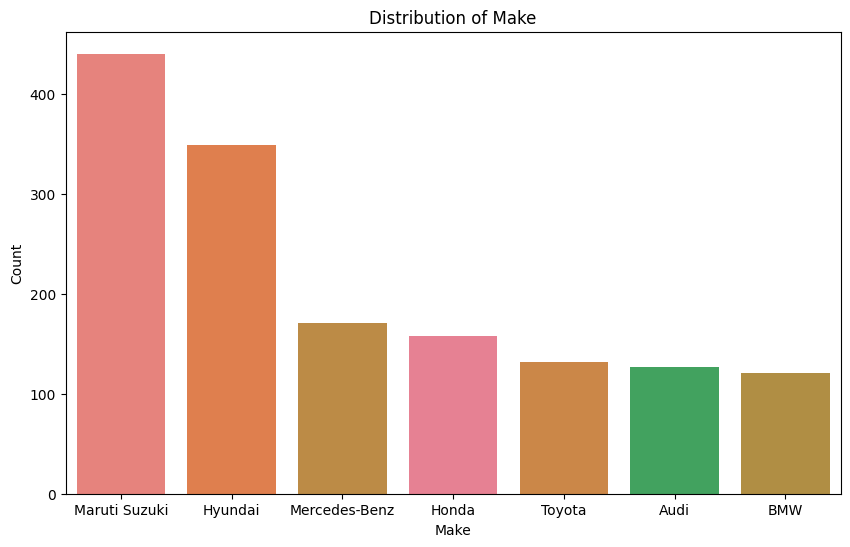

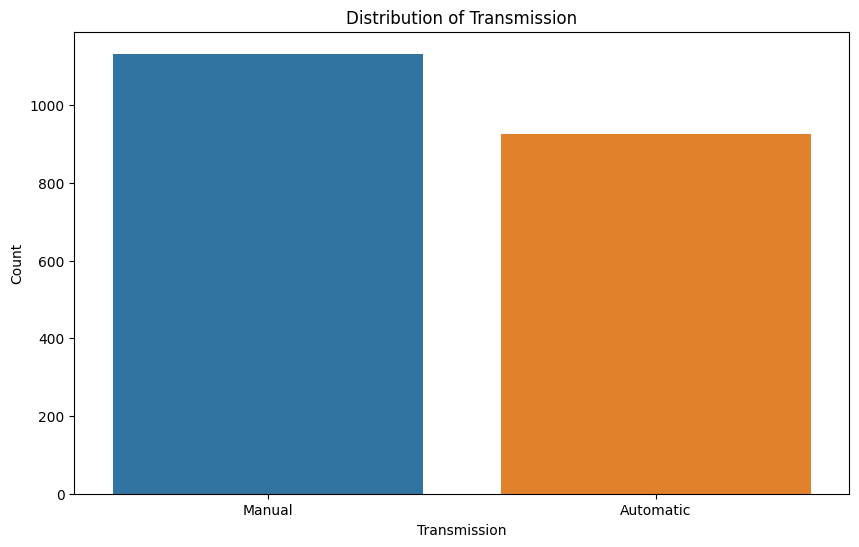

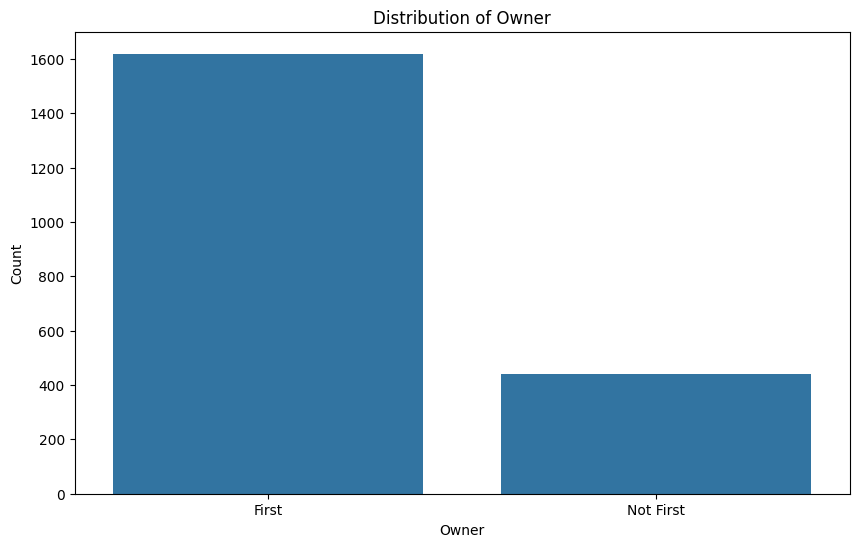

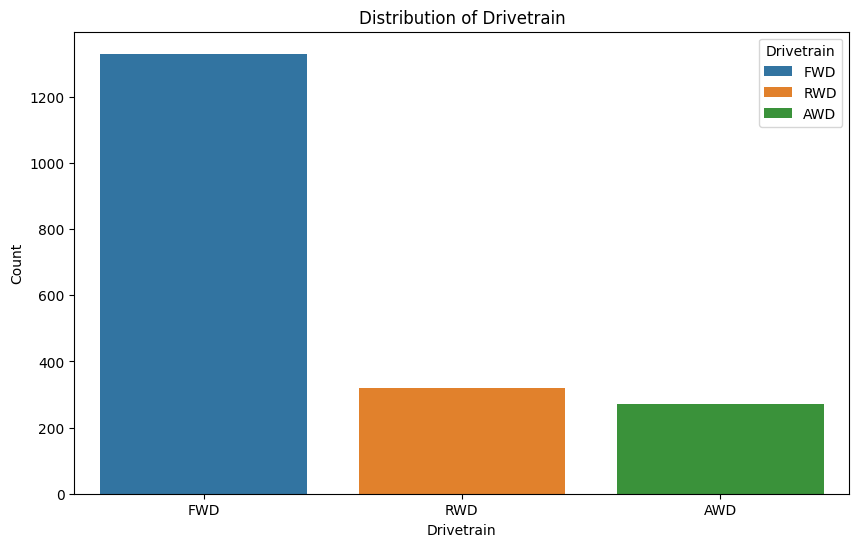

In [34]:

# Define the columns and their respective limits
column_limits = {
    'Make': 7,
    'Transmission': 2,
    'Owner': 2,
    'Drivetrain': 3
}

# For owner, separate 'First' and 'Not First'
df['Owner_Category'] = df['Owner'].apply(lambda x: 'First' if x == 'First' else 'Not First')

# Loop through each specified column and its limit
for col, limit in column_limits.items():
    plt.figure(figsize=(10, 6))
    if col == 'Owner':
        # Use the new 'Owner_Category' for the owner column
        sns.countplot(x='Owner_Category', data=df)
    else:
        # Display count plot for the column
        sns.countplot(x=col, hue=col, data=df, order=df[col].value_counts().index[:limit])
    
    # Set title and labels
    plt.title(f'Distribution of {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')

    # Show the plot for each column
    plt.show()

Here are additional cleaned up histograms for Make, Transmission, Owner (Split into First time or not), and Drivetrain. It is interesting ~80% of vehicles are listed as being sold by their first owner. Additionally, a majority of the vehicles are manual.

In [35]:
'''Step 6. Initial Data Transformation and Feature Engineering

Use pandas and other tools to perform transformations as needed. 
Transformation may include renaming columns, adding new columns, 
or transforming existing data for more in-depth analysis.'''

# Renaming column
df.rename(columns={'Max_Power': 'Max Power'}, inplace=True)
df.rename(columns={'Max_Torque': 'Max Torque'}, inplace=True)



# Adding a new column for 'Vehicular Volume'
df['Vehicular Volume'] = df['Length'] * df['Width'] * df['Height']



# Ensure that 'Max_Power' and 'Max_Torque' are treated as strings for extraction
df['Max Power'] = df['Max Power'].astype(str)
df['Max Torque'] = df['Max Torque'].astype(str)

# Split Max_Power into two new columns: Max_Power_bhp and Max_Power_rpm
df[['Max_Power_bhp', 'Max_Power_rpm']] = df['Max Power'].str.extract(r'(\d+)\s*bhp\s*@\s*(\d+)\s*rpm')

# Split Max_Torque into two new columns: Max_Torque_Nm and Max_Torque_rpm
df[['Max_Torque_Nm', 'Max_Torque_rpm']] = df['Max Torque'].str.extract(r'(\d+)\s*Nm\s*@\s*(\d+)\s*rpm')

# Convert the new columns to numeric types (float or int), coercing errors
df['Max_Power_bhp'] = pd.to_numeric(df['Max_Power_bhp'], errors='coerce')
df['Max_Power_rpm'] = pd.to_numeric(df['Max_Power_rpm'], errors='coerce')
df['Max_Torque_Nm'] = pd.to_numeric(df['Max_Torque_Nm'], errors='coerce')
df['Max_Torque_rpm'] = pd.to_numeric(df['Max_Torque_rpm'], errors='coerce')


Max Power and Max Torque were retitled, and split into new rows Max bhp|Nm and rpm, to be used as integers.

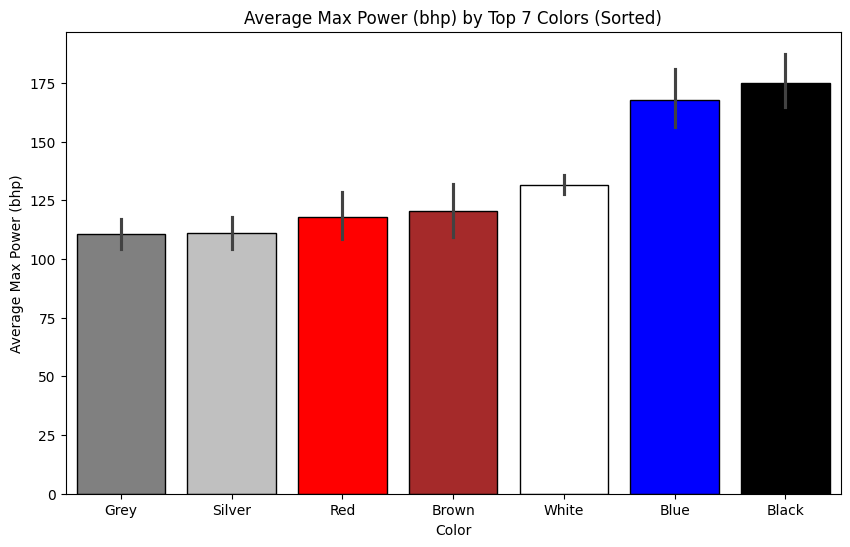

In [36]:
# Define the color mapping for the bar plot
color_mapping = {
    'White': 'white',
    'Silver': 'silver',
    'Grey': 'grey',
    'Blue': 'blue',
    'Black': 'black',
    'Red': 'red',
    'Brown': 'brown'
}

# Calculate the average Max_Power_bhp for each color
color_avg_max_power = df.groupby('Color')['Max_Power_bhp'].mean()

# Get the top 7 colors based on the count of occurrences
top_colors = df['Color'].value_counts().nlargest(7).index

# Filter the dataset to only include rows with the top 7 colors
df_top_colors = df[df['Color'].isin(top_colors)]

# Sort the color_avg_max_power by the average Max_Power_bhp in ascending order
sorted_colors = color_avg_max_power.loc[top_colors].sort_values().index

# Plot the histogram, sorting colors from least to greatest by average Max_Power_bhp
plt.figure(figsize=(10, 6))
bars = sns.barplot(
    x='Color', 
    y='Max_Power_bhp', 
    data=df_top_colors, 
    order=sorted_colors, 
    dodge=False,  # Disable dodge
    edgecolor='black'  # Add black outlines to the bars
)

# Set the colors manually for each bar to match the colors in the color_mapping
for bar, color in zip(bars.patches, sorted_colors):
    bar.set_facecolor(color_mapping[color])  # Set the face color from color_mapping

# Set plot title and labels
plt.title('Average Max Power (bhp) by Top 7 Colors (Sorted)')
plt.xlabel('Color')
plt.ylabel('Average Max Power (bhp)')

# Display the plot
plt.show()



Here are the top 7 most common colors, with Black showing up most frequently.

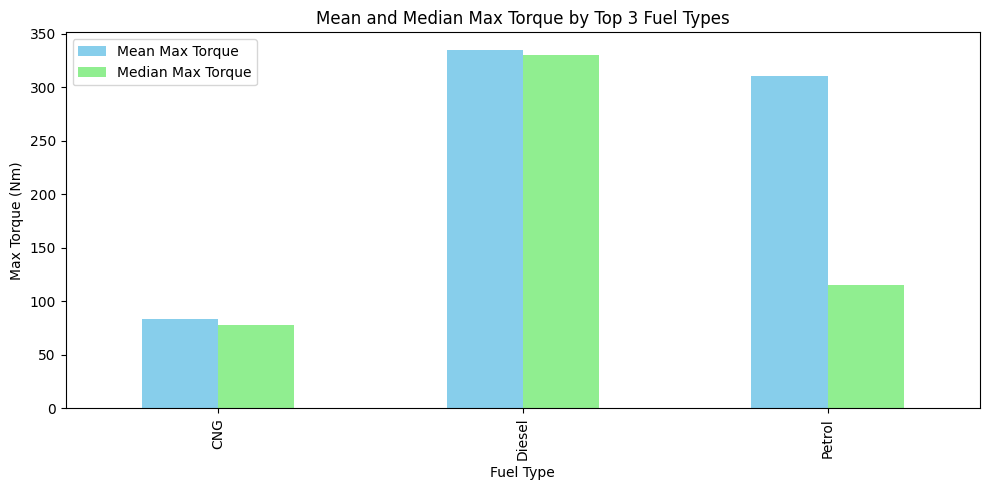

In [37]:

# Count the occurrences of each Fuel_Type and get the top 3
top_fuel_types = df['Fuel_Type'].value_counts().nlargest(3).index

# Filter the DataFrame to only include the top 4 Fuel_Types
df_filtered = df[df['Fuel_Type'].isin(top_fuel_types)]

# Group by Fuel_Type to calculate average and median Max_Torque
mean_areas = df_filtered.groupby('Fuel_Type')[['Max_Torque_Nm']].mean().rename(columns={'Max_Torque_Nm': 'Mean Max Torque'})
median_areas = df_filtered.groupby('Fuel_Type')[['Max_Torque_Nm']].median().rename(columns={'Max_Torque_Nm': 'Median Max Torque'})

# Concatenate the mean and median areas into a single DataFrame
combined_areas = pd.concat([mean_areas, median_areas], axis=1)

# Plotting
plt.figure(figsize=(10, 5))
combined_areas.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightgreen'])

# Set title and labels
plt.title('Mean and Median Max Torque by Top 3 Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Max Torque (Nm)')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

We can see that while Diesel and Petrol have close average Max Torques. However when we review the medians, we can see that a set of outliers in the Petrol set pulled the average much higher. Overall, if you pick a Diesel car and Petrol car at random, the Diesel car is more likely to have higher torque.

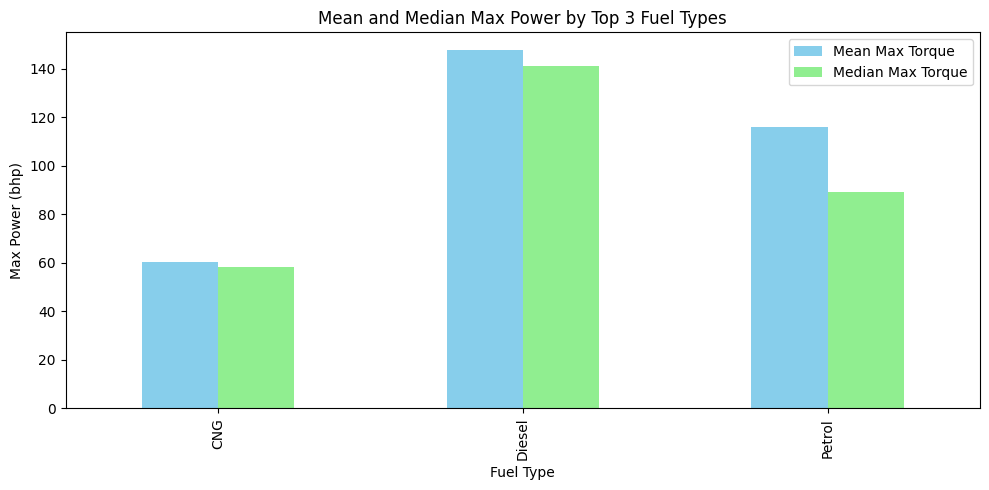

In [38]:
# Assuming df is already defined and contains the necessary data
# Count the occurrences of each Fuel_Type and get the top 3
top_fuel_types = df['Fuel_Type'].value_counts().nlargest(3).index

# Filter the DataFrame to only include the top 4 Fuel_Types
df_filtered = df[df['Fuel_Type'].isin(top_fuel_types)]

# Group by Fuel_Type to calculate average and median Max_Torque
mean_areas = df_filtered.groupby('Fuel_Type')[['Max_Power_bhp']].mean().rename(columns={'Max_Power_bhp': 'Mean Max Torque'})
median_areas = df_filtered.groupby('Fuel_Type')[['Max_Power_bhp']].median().rename(columns={'Max_Power_bhp': 'Median Max Torque'})

# Concatenate the mean and median areas into a single DataFrame
combined_areas = pd.concat([mean_areas, median_areas], axis=1)

# Plotting
plt.figure(figsize=(10, 5))
combined_areas.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightgreen'])

# Set title and labels
plt.title('Mean and Median Max Power by Top 3 Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Max Power (bhp)')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

The Diesel Engines in the set consistently have higher power than the Petrol engines.

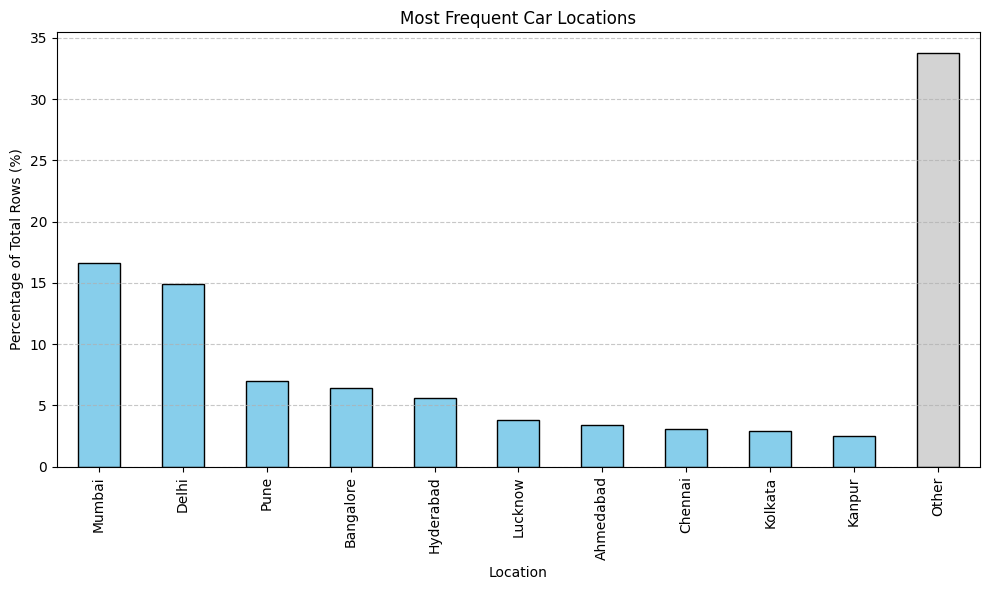

In [39]:


# Count the occurrences of each location and get the top 10
top_locations = df['Location'].value_counts().nlargest(10)

# Calculate the percentage of each location
total_rows = len(df)
percentages = (top_locations / total_rows) * 100

# Calculate percentage for "Other" locations
other_count = total_rows - top_locations.sum()
other_percentage = (other_count / total_rows) * 100

# Add "Other" to the percentages Series
percentages['Other'] = other_percentage

# Plotting
plt.figure(figsize=(10, 6))
percentages.plot(kind='bar', color=['skyblue'] * 10 + ['lightgrey'], edgecolor='black')

# Set title and labels
plt.title('Most Frequent Car Locations')
plt.xlabel('Location')
plt.ylabel('Percentage of Total Rows (%)')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

Lastly, as we can see from the cities listed, a majority of the cars in this dataset hail from India. Note ~33% of the vehicles are from cities not listed in the top 10 most common.